# <font color='#4C5FDA'>**Segmentación de imágenes de vehiculos** </font> <a name="tema1">

https://www.kaggle.com/c/carvana-image-masking-challenge

In [1]:
#@title **Importamos librerías necesarias**

# Pytorch essentials
import torch
import torch.nn as nn

# Pytorch essentials for datasets.
from torch.utils.data import Dataset, DataLoader, random_split

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

# PyTorch torchvision
import torchvision

# Manipulación de datos (imágenes)
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# Data agumentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Barra de carga 
from tqdm import tqdm

## <font color='#ECA702'>**Configuración inicial para conectarnos con Kaggle**</font>

In [5]:
! pip install kaggle

Defaulting to user installation because normal site-packages is not writeable


Subimos nuestro token de autenticación de Kaggle

In [ ]:
from google.colab import files
files.upload()

1. Creamos los directorios de Kaggle
2. Copiamos nuestro token en .kaggle
3. Con `chmod 600` establecemos los permitos del token en 600, es decir, que solo yo tengo permisos de lectura y escritura sobre el archivo

In [11]:
! mkdir ~/kaggle

mkdir: cannot create directory ‘/home/guillermo/kaggle’: File exists


In [12]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/home/guillermo/.kaggle’: File exists


## <font color='#ECA702'>**Procesamiento del dataset**</font>

### <font color='#52F17F'>**Carga del dataset**</font>

Traemos el dataset [Carvana Image Masking](https://www.kaggle.com/datasets/ipythonx/carvana-image-masking-png)
 desde kaggle.

In [14]:
! kaggle datasets download -d ipythonx/carvana-image-masking-png
! unzip carvana-image-masking-png.zip


Dataset URL: https://www.kaggle.com/datasets/ipythonx/carvana-image-masking-png
License(s): copyright-authors
100%|███████████████████████████████████████▉| 827M/828M [01:18<00:00, 10.7MB/s]
100%|████████████████████████████████████████| 828M/828M [01:18<00:00, 11.1MB/s]


### <font color='#52F17F'>**Creación del Dataset PyTorch**</font>

In [2]:
class CarvanaDataset(Dataset):
  def __init__(self, image_dir, mask_dir):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.images = os.listdir(image_dir) # Listamos todas las imagenes en la carpeta

  def __len__(self):
    return len(self.images)
  
  def __getitem__(self, index):
    
    """ Carga de la imagen """

    # Entramos a la carpeta y conseguimos la imagen de la lista
    img_path = os.path.join(self.image_dir, self.images[index])

    # Leemos la imagen y la pasamo a RGB
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    """ Carga de la máscara """

    # Entramos a la carpeta y conseguimos la mascara de la lista.
      # La razon por la que uso la misma lista de imagenes es porque la imagen y la mascara
      # tienen el mismo nombre, solo cambia la ruta de la carpeta y la extensión.
    """ image: data/train_images/0cdf5b5d0ce1_01.jpg """
    """ mask: data/train_masks/0cdf5b5d0ce1_01.png """
    mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", ".png"))

    # Leemos la mascara en escala de grises
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Binarizamos la mascara
    mask[mask==255.0] = 1.0

    return img, mask

In [3]:
"""" 
El siguiente Dataset lo creé ya que por la estructura de los datos
tengo que separar los datos para entrenamiento y testeo a partir del dataset
completo, entonces luego de tener el dataset completo armado tengo que sacar 
el dataset de train y luego el de testeo con random split y a esos dos aplicarles
las respectivas transformaciones.
 """

class ModelCarvanaDataset(Dataset):
  def __init__(self, dataset, transform = None):
    self.dataset = dataset
    self.transform = transform

  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, index):
    
    """ Carga de la imagen """
    # Leemos la imagen 
    img = self.dataset[index][0]

    """ Carga de la máscara """
    # Leemos la mascara 
    mask = self.dataset[index][1]

    """ Data augmentation """
    if self.transform:
      # Aplicamos las transformaciones a la máscara e imagen
      augmentations = self.transform(image=img, mask=mask) 

      # Lo anterior nos devuelve un diciconario, entonces conseguimos la máscara e imagen de ese diccionario
      img, mask = augmentations['image'], augmentations['mask']

    return img, mask.float().unsqueeze(0)

### <font color='#52F17F'>**Visualización de datos**</font>

In [115]:
def visualize_data(dataset, size=4):
  plt.figure(figsize=(8, 10))
  for i in range(1, size*2 + 1, 2): # 1, 3, 5, 7
      img = dataset[i][0]
      mask = dataset[i][1]
      plt.subplot(size, 2, i); plt.imshow(img)
      plt.subplot(size, 2, i + 1); plt.imshow(mask, cmap='gray')
  plt.show()

In [4]:
IMAGES_PATH = "data/train_images"
MASKS_PATH = "data/train_masks"
dataset = CarvanaDataset(IMAGES_PATH, MASKS_PATH)

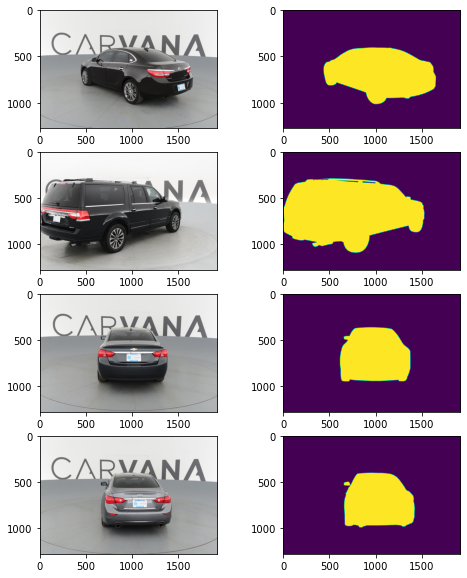

In [21]:
visualize_data(dataset)

### <font color='#52F17F'>**Data augmentation**</font>

In [6]:
# Para hacer resize conservando la relación de aspecto
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

train_transform = A.Compose([
  A.Resize(height = IMAGE_HEIGHT, width = IMAGE_WIDTH),
  A.Rotate(limit=35, p=1.0),
  A.HorizontalFlip(p=0.5),
  A.VerticalFlip(p=0.1),
  A.Normalize(
    mean = [0.0, 0.0, 0.0],
    std = [1.0, 1.0, 1.0],
    max_pixel_value = 255.0
  ),
  ToTensorV2()
])

test_transform = A.Compose([
  A.Resize(height = IMAGE_HEIGHT, width = IMAGE_WIDTH),
  A.Normalize(
    mean = [0.0, 0.0, 0.0],
    std = [1.0, 1.0, 1.0],
    max_pixel_value = 255.0
  ),
  ToTensorV2()
])

## <font color='#ECA702'>**Modelo CNN**</font>

**U-net architecture**

The network architecture is illustrated in Figure 1. It consists of a contracting
path (left side) and an expansive path (right side). The contracting path follows
the typical architecture of a convolutional network. It consists of the repeated
application of two 3x3 convolutions (unpadded convolutions), each followed by
a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2
for downsampling. At each downsampling step we double the number of feature
channels. Every step in the expansive path consists of an upsampling of the
feature map followed by a 2x2 convolution (“up-convolution”) that halves the
number of feature channels, a concatenation with the correspondingly cropped
feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU. The cropping is necessary due to the loss of border pixels
in every convolution. At the final layer a 1x1 convolution is used to map each
64-component feature vector to the desired number of classes. In total the network has 23 convolutional layers.

<div align="center"> <image src="https://imgs.search.brave.com/6lbIK-xzYuzh28AextLXfu6l0sxRrVbSexgE3eSLp_Q/rs:fit:860:0:0/g:ce/aHR0cHM6Ly9tZWRp/YS5nZWVrc2Zvcmdl/ZWtzLm9yZy93cC1j/b250ZW50L3VwbG9h/ZHMvMjAyMjA2MTQx/MjEyMzEvR3JvdXAx/NC5qcGc" width=600>  </div>

### <font color='#52F17F'>**Creando el modelo**</font>

In [101]:
class DoubleConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
     super().__init__()
     #Declara las capas necesarias para realizar la doble convolución descrita en
     # el diagrama de la UNet
     self.double_conv = nn.Sequential(
         nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
         nn.ReLU(inplace=True),
         nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
         nn.ReLU(inplace=True)
     )

  def forward(self, x):
    return self.double_conv(x)


class Downscaling(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv = DoubleConvBlock(in_channels, out_channels)

  def forward(self, x):
    p = self.pool(x)
    down = self.conv(p)
    return x, down


class Upscaling(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    ## Declara las capas necesarias para aumentar la escala de los mapas de caracteristicas
    ## Puedes emplear interpolación o convolución transpuesta para lograrlo
    self.up_conv = nn.ConvTranspose2d(in_channels, in_channels//2, 2, stride=2)
    self.conv = DoubleConvBlock(in_channels, out_channels)

  def forward(self, x1, x2):
    x1 = self.up_conv(x1)
    x = torch.cat([x1, x2], 1)
    return self.conv(x)


class OutConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, 1)

  def forward(self, x):
    return self.conv(x)

In [102]:
class UNet(nn.Module):
  def __init__(self, n_channels, n_classes):
    super().__init__()

    self.n_channels = n_channels
    self.n_classes = n_classes

    ## Siguiendo la estructura de la Unet, crea el modelo con los bloques declarados arriba
    self.inc = DoubleConvBlock(n_channels, 64) # 3x572x572 to 64x568x568
    self.down1 = Downscaling(64, 128) # 64x568x568 to 128x280x280
    self.down2 = Downscaling(128, 256) # 6128x280x280 to 256x136x136
    self.down3 = Downscaling(256, 512) # 256x136x136 to 512x64x64
    self.down4 = Downscaling(512, 1024) # 512x64x64 to 1024x28x28

    self.up_conv1 = Upscaling(1024, 512)
    self.up_conv2 = Upscaling(512, 256)
    self.up_conv3 = Upscaling(256, 128)
    self.up_conv4 = Upscaling(128, 64)

    self.out = OutConv(64, n_classes)

  def forward(self, x):
    ## Crea el forward de la UNet, no olvides las conexiones residuales

    # 3x572x572 to 64x568x568
    entrada = self.inc(x)

    # 64x568x568 to 128x280x280
    crop1, down1 = self.down1(entrada)

    # 6128x280x280 to 256x136x136
    crop2, down2 = self.down2(down1)

    # 256x136x136 to 512x64x64
    crop3, down3 = self.down3(down2)

    # 512x64x64 to 1024x28x28
    crop4, down4 = self.down4(down3)

    # 1024x28x28 to 512x52x52
    upsampling1 = self.up_conv1(down4, crop4)

    # 512x52x52 to 256x100x100
    upsampling2 = self.up_conv2(upsampling1, crop3)

    # 256x100x100 to 128x196x196
    upsampling3 = self.up_conv3(upsampling2, crop2)

    # 128x196x196 to 64x388x388
    upsampling4 = self.up_conv4(upsampling3, crop1)

    # 64x388x388 to 1x388x388
    salida = self.out(upsampling4)
    return salida

In [103]:
# Test al modelo, para ver si nos entrega la salida esperada

n_channels = 3
n_classes = 1
input_image = torch.rand((1, n_channels, IMAGE_WIDTH, IMAGE_HEIGHT))
# input_image = torch.rand((1, 3, 6, 6))
print(f"Entrada: {input_image.size()}")
model = UNet(n_channels=n_channels, n_classes=n_classes)
ouput = model(input_image)
print(f"Salida: {ouput.size()}") # Esperado: [1, 10, 512, 512]

Entrada: torch.Size([1, 3, 256, 256])
Salida: torch.Size([1, 1, 256, 256])


### <font color='#52F17F'>**Entrenamiento del modelo**</font>

In [8]:
# Hiperparametros
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 4

In [9]:
# Random split
train_dataset, test_dataset = random_split(dataset, [.8, .2])
train_dataset = ModelCarvanaDataset(train_dataset, train_transform)
test_dataset = ModelCarvanaDataset(test_dataset, test_transform)

# Dataloader
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False)

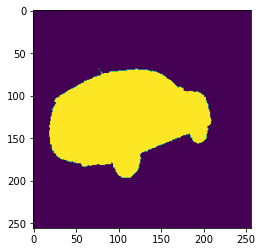

In [13]:
plt.imshow(train_dataset[0][1].squeeze(0))

In [105]:
""" Parametros del modelo """

# Creacion del modelo y lo movemos a la GPU o CPU
model = UNet(n_channels=3, n_classes=1)
model.to(DEVICE)

# Funcion de perdida (loss)
criterion = nn.BCEWithLogitsLoss()

# Algoritmos de optimización del gradiente
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [106]:
""" Entrenamiento de una época """
def train_one_epoch(train_loader, epoch_index, tb_writer):
  running_loss = 0.
  for i, batch in enumerate(train_loader):
    img = batch[0].to(DEVICE)
    mask = batch[1].to(DEVICE)

    # Reseteamos los gradientes. Se puede antes o después de realizar la predicción.
    # Depende de nuestro caso. Pero nunca entre el loss.backward() y optimizer.step()
    optimizer.zero_grad()

    """ forward """
    # Hacemos las predicciones
    pred = model(img)

    """ backward """
    # Calculamos el error
    loss = criterion(pred, mask)
    running_loss += loss.item()

    # Cada n batchs muestra el error. En este caso quiero que muestre el error
    # cada 100 batches.
    if i % 100 == 99:

      # Divido el loss entre i+1, porque va a ser 100, 200, ..
      # que es la cantidad de batches hasta el momento. Entonces, esto me va a mostrar
      # el error que va acumulando la época.
      print(f"batch {i+1} loss: {running_loss/ (i + 1)}")
      tb_x = epoch_index * len(train_loader) + i +1
      tb_writer.add_scalar('Loss/train', running_loss/ (i + 1), tb_x)
      # running_loss = 0

    # Propagamos el error
    loss.backward() 

    # Ajustamos los pesos
    optimizer.step()

  return running_loss / (i+1)


In [108]:
def validate_one_epoch(test_loader):
  runnning_vloss = 0.

  model.eval()
  for i, vdata in enumerate(test_loader):
    img = vdata[0].to(DEVICE)
    mask = vdata[1].to(DEVICE)

    # Hacemos las predicciones
    pred = torch.sigmoid(model(img))
    pred = (pred > 0.5).float()

    # Calculamos el loss
    vloss = criterion(pred, mask)
    runnning_vloss += vloss
  
  return runnning_vloss / (i + 1)


In [109]:
""" Para guardar datos del modelo cada vez que cambiemos los parametros """

# Se inicializa en una celda separada, así podemos añadir facilmente epocas al mismo run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(f'runs/carvana_trainer_{timestamp}')
model_folder_path = f'models/carvana_model_{timestamp}'
model_folder = os.mkdir(model_folder_path)
epoch_number = 0

In [110]:
EPOCHS = 2

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
  print(f'EPOCH {epoch_number + 1}')

  # Activamos las capas de entrenamiento
  model.train(True)

  avg_loss = train_one_epoch(train_loader, epoch_number, writer)

  # Apagamos el modo entrenamiento. Es equivalente a model.eval()
  # model.train(False)

  # Testeamos el modelo en la época actual
  avg_vloss = validate_one_epoch(test_loader)
  print(f"LOSS train: {avg_loss} valid: {avg_vloss}")

  writer.add_scalars('Training vs. Loss',
                     {'Training': avg_loss,
                      'Validation': avg_vloss},
                      epoch_number + 1)
  writer.flush()

  # Guardamos mejor modelo de las épocas
  if avg_vloss < best_vloss:
    best_vloss = avg_vloss
    model_path = f"model_{timestamp}_{epoch_number + 1}.pth"
    torch.save(model.state_dict(), f"{model_folder_path}/{model_path}")

  epoch_number += 1

batch 100 loss: 0.46514269173145295
batch 200 loss: 0.33790344536304473
batch 300 loss: 0.271840443611145
batch 400 loss: 0.23072488277219236
batch 500 loss: 0.20352221532911063
batch 600 loss: 0.1827410136287411
batch 700 loss: 0.16946065545614278
batch 800 loss: 0.16117560470011086
batch 900 loss: 0.15005185650454628
batch 1000 loss: 0.14322026899829507
LOSS train: 0.1416762602645428 valid: 0.6281583905220032
batch 100 loss: 0.05177454899996519
batch 200 loss: 0.051317480355501176
batch 300 loss: 0.04922800053531925
batch 400 loss: 0.04816488550044596
batch 500 loss: 0.04664142521843314
batch 600 loss: 0.04566940399507682
batch 700 loss: 0.04405229943405305
batch 800 loss: 0.042992015071213245
batch 900 loss: 0.04183151505266627
batch 1000 loss: 0.04139688548259437
LOSS train: 0.041165306693956634 valid: 0.622985303401947


## <font color='#ECA702'>**Evaluación del modelo**</font>

In [111]:
""" Cargamos un modelo entrenado """
path_model = "models/carvana_model_20240508_153205/model_20240508_153205_1.pth"
model.load_state_dict(torch.load(path_model))
model.to(DEVICE)
# Apagamos el modo entrenamiento. Es equivalente a model.eval()
model.eval()
# Para verificar si mi modelo está en modo entrenamiento
model.training


False

### <font color='#52F17F'>**Métricas del modelo**</font>

In [80]:
""" Testeo y métricas de una época """
def test_one_epoch(model, test_loader):
  num_correct = 0
  num_pixels = 0
  dice_score = 0
  
  # loop = tqdm(test_loader)
  # Desactivamos el motor Autograd que calcula los gradientes con respecto a los parámetros
  with torch.no_grad():
    for img, mask in tqdm(test_loader):

      # Obtenemos las imagenes y máscaras del batch
      img = img.to(DEVICE)
      mask = mask.to(DEVICE)

      # Hacemos las predicciones
      pred = torch.sigmoid(model(img))
      pred = (pred > 0.5).float()

      # Calculamos la cantidad de pixeles que predijo bien
      num_correct += (pred == mask).sum()
      num_pixels += torch.numel(pred)

      # Calculamos el Dice score
      dice_score += (2 * (pred * mask).sum()) / ((pred + mask).sum() + 1e-8)

  print(f"Got {num_correct}/{num_pixels} with acc: {num_correct/num_pixels*100:.2f}")
  print(f"Dice score: {dice_score/len(test_loader)}")

In [112]:
test_one_epoch(model, test_loader)

100%|██████████| 255/255 [01:03<00:00,  4.03it/s]


Got 65594253/66650112 with acc: 98.42
Dice score: 0.9632508754730225


100%|██████████| 255/255 [01:02<00:00,  4.06it/s]

Got 65594253/66650112 with acc: 98.42
Dice score: 0.9632508754730225


### <font color='#52F17F'>**Inferencia del modelo**</font>

In [ ]:
""" Segmentación binaria: Ver los resultados de un modelo tomando muestras de un Dataset """

def visualize_results(model, dataset, num_samples=4):
  random_list = np.random.choice(len(dataset), num_samples, replace=False)

  fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

  for i, idx in enumerate(random_list):
    sample = dataset[idx]
    mask = sample[1].squeeze(0).cpu()
    img = sample[0].unsqueeze(0).to(DEVICE)
    pred = torch.sigmoid(model(img))
    pred = (pred > 0.5).squeeze(0).squeeze(0).float().cpu()
    img = img.squeeze(0).permute(1, 2, 0).cpu()
                
    axes[i, 0].imshow(img); axes[i, 0].set_title('Input')
    axes[i, 1].imshow(pred, cmap='gray'); axes[i, 1].set_title('Prediction')
    axes[i, 2].imshow(mask, cmap='gray'); axes[i, 2].set_title('Ground Truth')

  plt.tight_layout()
  plt.show()

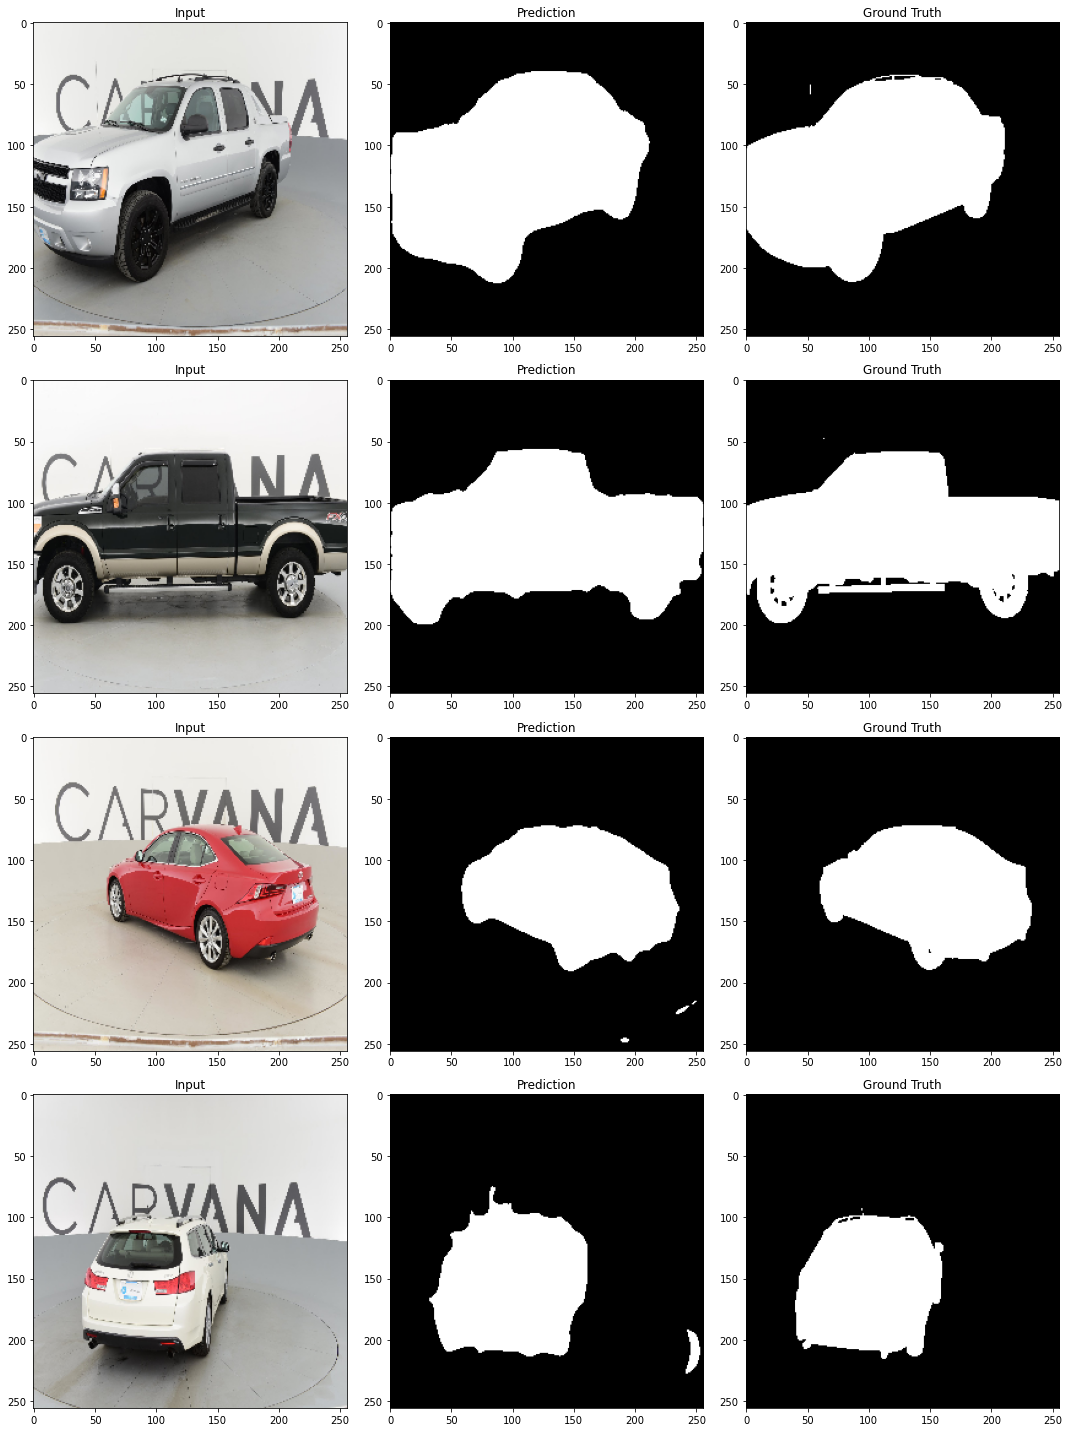

In [114]:
show_imgs = 4
random_list = np.random.choice(len(test_dataset), show_imgs, replace=False)

fig, axes = plt.subplots(show_imgs, 3, figsize=(15, 5 * show_imgs))

for i, idx in enumerate(random_list):
    sample = test_dataset[idx]
    mask = sample[1].squeeze(0).cpu()
    img = sample[0].unsqueeze(0).to(DEVICE)
    pred = torch.sigmoid(model(img))
    pred = (pred > 0.5).squeeze(0).squeeze(0).float().cpu()
    img = img.squeeze(0).permute(1, 2, 0).cpu()
                
    axes[i, 0].imshow(img); axes[i, 0].set_title('Input')
    axes[i, 1].imshow(pred, cmap='gray'); axes[i, 1].set_title('Prediction')
    axes[i, 2].imshow(mask, cmap='gray'); axes[i, 2].set_title('Ground Truth')

plt.tight_layout()
plt.show()